# Modeling
## Classification

in this notebook we are going to apporach the classification problem, our available datasets consits of two classification problems, binary and multiclass. although some machine learning algorithms are capable of both, there are some which can only do binary or multiclass classification. so, if a specific algorithm is not performed for a dataset, its because that datasets classification problem couldn't be done with that specific algorithm.

----


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import matplotlib
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
import seaborn as sns
from openpyxl import load_workbook
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from tqdm import tqdm_notebook, tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import itertools
import seaborn as sns

In [172]:
xls = pd.ExcelFile("data/main dataset v3.0 .xlsx")
ad_post = pd.read_excel(xls, 'Ad-Post')
ad_story = pd.read_excel(xls, 'Ad-Story')
influencer = pd.read_excel(xls, 'Influencer')
leaders_post = pd.read_excel(xls, 'Leaders-Post')
leaders_story = pd.read_excel(xls, 'Leaders-Story')
post = pd.read_excel(xls, 'Post')
story = pd.read_excel(xls, 'Story')
print('Datasets Loaded Completely.')

Datasets Loaded Completely.


In [173]:
#dummying dataset

# advertising posts
dummy_field = pd.get_dummies(ad_post['field'], prefix='field')
ad_post_dummy = pd.concat([ad_post, dummy_field], axis=1)
ad_post_dummy.drop(['field'], axis=1, inplace=True)

# advertising stories
dummy_field = pd.get_dummies(ad_story['field'], prefix='field')
ad_story_dummy = pd.concat([ad_story, dummy_field], axis=1)
ad_story_dummy.drop(['field'], axis=1, inplace=True)

#influencer
dummy_gender = pd.get_dummies(influencer['gender'], prefix='gender')
dummy_field = pd.get_dummies(influencer['field'], prefix='field')
influencer_dummy = pd.concat([influencer, dummy_gender, dummy_field], axis=1)
influencer_dummy.drop(['gender', 'field'], axis=1, inplace=True)

#leaders posts
dummy_gender = pd.get_dummies(leaders_post['gender'], prefix='gender')
leaders_post_dummy = pd.concat([leaders_post, dummy_gender], axis=1)
leaders_post_dummy.drop(['gender'], axis=1, inplace=True)

In [174]:
# label encoding dataset

# advertising posts
labels, _ = pd.factorize(ad_post['field'])
ad_post_labelencoded = ad_post
ad_post_labelencoded['field_labelencoded'] = labels.tolist()

# advertising stories
labels, _ = pd.factorize(ad_story['field'])
ad_story_labelencoded = ad_story
ad_story_labelencoded['field_labelencoded'] = labels.tolist()

# influencer
labels, _ = pd.factorize(influencer['gender'])
influencer_labelencoded = influencer
influencer_labelencoded['gender_labelencoded'] = labels.tolist()
labels, _ = pd.factorize(influencer['field'])
influencer_labelencoded['field_labelencoded'] = labels.tolist()

# leaders post
labels, _ = pd.factorize(leaders_post['gender'])
leaders_post_labelencoded = leaders_post
leaders_post_labelencoded['gender_labelencoded'] = labels.tolist()

In [175]:
ad_post_y = np.asarray(ad_post_dummy[['benefit']])
ad_post_x = np.asarray(ad_post_dummy[['follower', 'view', 'cost', 'field_art & culture', 'field_fact', 'field_video', 'field_women']])


ad_story_y = np.asarray(ad_story_dummy[['benefit']])
ad_story_x = np.asarray(ad_story_dummy[['view', 'follower', 'action', 'interaction', 'impression', 'cost', 'field_art & culture', 'field_fact', 'field_health',
                                       'field_news', 'field_video', 'field_women']])

influencer_y = np.asarray(influencer_dummy[['benefit']])
influencer_x = np.asarray(influencer_dummy[['follower', 'view', 'action', 'impression', 'cta', 'interaction', 'cost', 'gender_family', 'gender_female', 'gender_male',
                                           'field_cooking', 'field_health', 'field_lifestyle', 'field_sport', 'field_tourism']])

leaders_post_y = np.asarray(leaders_post_dummy[['benefit']])
leaders_post_x = np.asarray(leaders_post_dummy[['follower', 'view', 'like', 'comment', 'share', 'save', 'profile_visit', 'reach', 'impression', 'cost', 'gender_family',
                                               'gender_female', 'gender_male']])

### Logistic Regression (Both)
#### Advertising Post

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

Normalizing independent variables:

In [177]:
ad_post_x = preprocessing.StandardScaler().fit(ad_post_x).transform(ad_post_x)
ad_story_x = preprocessing.StandardScaler().fit(ad_story_x).transform(ad_story_x)
influencer_x = preprocessing.StandardScaler().fit(influencer_x).transform(influencer_x)
leaders_post_x = preprocessing.StandardScaler().fit(leaders_post_x).transform(leaders_post_x)

In [178]:
c_lst = [1, .5, .25, .1, .05, .025, .01, .005, .0025, .001]

In [179]:
temp_lst = []
for i in range(2, 6):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_post_x):
        X_train, X_test = ad_post_x[train_index], ad_post_x[test_index]
        y_train, y_test = ad_post_y[train_index], ad_post_y[test_index]
        for c in c_lst:
            clf_lr = LogisticRegression(penalty='l2', C=c, solver='liblinear')
            clf_lr.fit(X_train, y_train)
            y_hat = clf_lr.predict(X_test)
            y_hat_prob = clf_lr.predict_proba(X_test)
            temp_lst2 = []
            temp_lst2.append(i)
            temp_lst2.append(c)
            temp_lst2.append(metrics.accuracy_score(y_train, clf_lr.predict(X_train)))
            temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
            temp_lst2.append(metrics.f1_score(y_test, y_hat))
            temp_lst2.append(metrics.jaccard_score(y_test, y_hat))
            temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst,
                       columns=['k', 'c', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
temp_lst = []
for k in range(2, 6):
    for c in c_lst:
        temp_lst2 = []
        temp_lst2.append(k)
        temp_lst2.append(c)
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Train-set Accuracy']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Test-set Accuracy']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['F1 Score']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Jaccard Score']), decimals=4))
        temp_lst.append(temp_lst2)
        
clf_lr_eval_df = pd.DataFrame(temp_lst,
                              columns=['k', 'c', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
clf_lr_eval_df

,k,c,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,0.85,0.63,0.70,0.54
1,2,0.50,0.81,0.59,0.64,0.47
2,2,0.25,0.81,0.59,0.64,0.47
3,2,0.10,0.81,0.52,0.58,0.41
4,2,0.05,0.81,0.52,0.58,0.41
5,2,0.03,0.81,0.56,0.60,0.43
6,2,0.01,0.81,0.56,0.60,0.43
7,2,0.01,0.81,0.56,0.60,0.43
8,2,0.00,0.81,0.56,0.60,0.43
9,2,0.00,0.81,0.56,0.60,0.43


In [180]:
clf_lr_eval_df.nlargest(3, 'Test-set Accuracy')

,k,c,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
13,3,0.10,0.78,0.78,0.73,0.67
14,3,0.05,0.76,0.78,0.72,0.63
10,3,1.00,0.87,0.74,0.72,0.66


In [181]:
kf = KFold(n_splits = 3)
temp_lst = []
clf_lr = LogisticRegression(penalty='l2', C=.10, solver='liblinear')
for train_index, test_index in kf.split(ad_post_x):
    X_train, X_test = ad_post_x[train_index], ad_post_x[test_index]
    y_train, y_test = ad_post_y[train_index], ad_post_y[test_index]
    clf_lr.fit(X_train, y_train)
    y_hat = clf_lr.predict(X_test)
    y_hat_prob = clf_lr.predict_proba(X_test)
    temp_lst2 = []
    temp_lst2.append(metrics.accuracy_score(y_train, clf_lr.predict(X_train)))
    temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
    temp_lst2.append(metrics.f1_score(y_test, y_hat))
    temp_lst2.append(metrics.jaccard_score(y_test, y_hat))
    temp_lst2.append(metrics.log_loss(y_test, y_hat_prob))
    temp_lst2.append(y_test)
    temp_lst2.append(y_hat)
    temp_lst2.append(X_test)
    temp_lst.append(temp_lst2)

In [182]:
temp_lst_ytest, temp_lst_yhat, temp_lst_xtest = [], [], []
for row in temp_lst:
    for i in row[5]:
        temp_lst_ytest.append(i)
    for j in row[6]:
        temp_lst_yhat.append(j)
    for k in row[7]:
        temp_lst_xtest.append(k)
    
cnf_ytest = np.array(temp_lst_ytest)
cnf_yhat = np.array(temp_lst_yhat)
cnf_xtest = np.array(temp_lst_xtest)
print(metrics.classification_report(cnf_ytest, cnf_yhat))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.76      0.87      0.81        15

    accuracy                           0.78        27
   macro avg       0.78      0.77      0.77        27
weighted avg       0.78      0.78      0.77        27



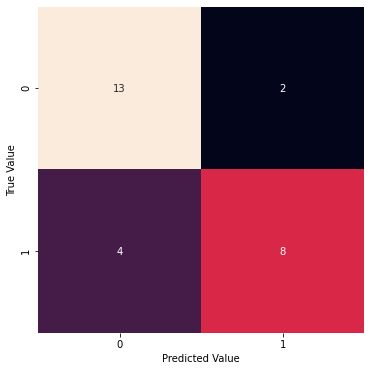

In [183]:
cnf_matrix = confusion_matrix(cnf_ytest, cnf_yhat, labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

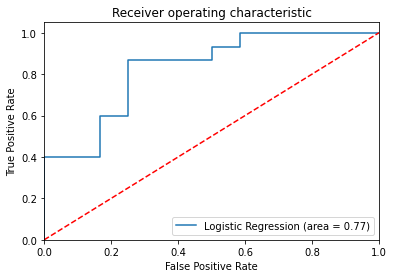

In [184]:
logit_roc_auc = roc_auc_score(cnf_ytest, clf_lr.predict(cnf_xtest))
fpr, tpr, thresholds = roc_curve(cnf_ytest, clf_lr.predict_proba(cnf_xtest)[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Advertising Stories

In [185]:
temp_lst = []
for i in range(2, 6):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_story_x):
        X_train, X_test = ad_story_x[train_index], ad_story_x[test_index]
        y_train, y_test = ad_story_y[train_index], ad_story_y[test_index]
        for c in c_lst:
            clf_lr = LogisticRegression(penalty='l2', C=c, solver='liblinear')
            clf_lr.fit(X_train, y_train)
            y_hat = clf_lr.predict(X_test)
            y_hat_prob = clf_lr.predict_proba(X_test)
            temp_lst2 = []
            temp_lst2.append(i)
            temp_lst2.append(c)
            temp_lst2.append(metrics.accuracy_score(y_train, clf_lr.predict(X_train)))
            temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
            temp_lst2.append(metrics.f1_score(y_test, y_hat))
            temp_lst2.append(metrics.jaccard_score(y_test, y_hat))
            temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst,
                       columns=['k', 'c', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
temp_lst = []
for k in range(2, 6):
    for c in c_lst:
        temp_lst2 = []
        temp_lst2.append(k)
        temp_lst2.append(c)
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Train-set Accuracy']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Test-set Accuracy']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['F1 Score']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Jaccard Score']), decimals=4))
        temp_lst.append(temp_lst2)
        
clf_lr_eval_df = pd.DataFrame(temp_lst,
                              columns=['k', 'c', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
clf_lr_eval_df

,k,c,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,0.96,0.82,0.84,0.72
1,2,0.50,0.93,0.82,0.84,0.72
2,2,0.25,0.93,0.82,0.84,0.72
3,2,0.10,0.93,0.78,0.81,0.68
4,2,0.05,0.93,0.70,0.75,0.60
5,2,0.03,0.89,0.66,0.70,0.55
6,2,0.01,0.85,0.66,0.70,0.55
7,2,0.01,0.82,0.66,0.70,0.55
8,2,0.00,0.82,0.63,0.67,0.52
9,2,0.00,0.82,0.63,0.67,0.52


In [186]:
clf_lr_eval_df.nlargest(3, 'Test-set Accuracy')

,k,c,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,0.96,0.82,0.84,0.72
1,2,0.50,0.93,0.82,0.84,0.72
2,2,0.25,0.93,0.82,0.84,0.72


In [187]:
kf = KFold(n_splits = 2)
temp_lst = []
clf_lr = LogisticRegression(penalty='l2', C=1, solver='liblinear')
for train_index, test_index in kf.split(ad_story_x):
    X_train, X_test = ad_story_x[train_index], ad_story_x[test_index]
    y_train, y_test = ad_story_y[train_index], ad_story_y[test_index]
    clf_lr.fit(X_train, y_train)
    y_hat = clf_lr.predict(X_test)
    y_hat_prob = clf_lr.predict_proba(X_test)
    temp_lst2 = []
    temp_lst2.append(metrics.accuracy_score(y_train, clf_lr.predict(X_train)))
    temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
    temp_lst2.append(metrics.f1_score(y_test, y_hat))
    temp_lst2.append(metrics.jaccard_score(y_test, y_hat))
    temp_lst2.append(metrics.log_loss(y_test, y_hat_prob))
    temp_lst2.append(y_test)
    temp_lst2.append(y_hat)
    temp_lst2.append(X_test)
    temp_lst.append(temp_lst2)

In [188]:
temp_lst_ytest, temp_lst_yhat, temp_lst_xtest = [], [], []
for row in temp_lst:
    for i in row[5]:
        temp_lst_ytest.append(i)
    for j in row[6]:
        temp_lst_yhat.append(j)
    for k in row[7]:
        temp_lst_xtest.append(k)
    
cnf_ytest = np.array(temp_lst_ytest)
cnf_yhat = np.array(temp_lst_yhat)
cnf_xtest = np.array(temp_lst_xtest)
print(metrics.classification_report(cnf_ytest, cnf_yhat))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.87      0.81      0.84        16

    accuracy                           0.81        27
   macro avg       0.81      0.82      0.81        27
weighted avg       0.82      0.81      0.82        27



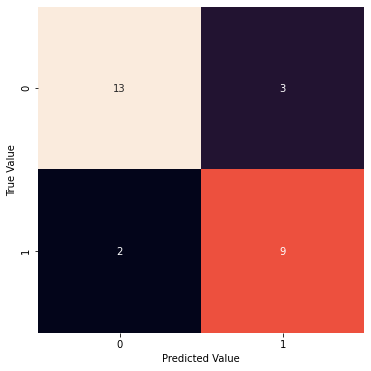

In [189]:
cnf_matrix = confusion_matrix(cnf_ytest, cnf_yhat, labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

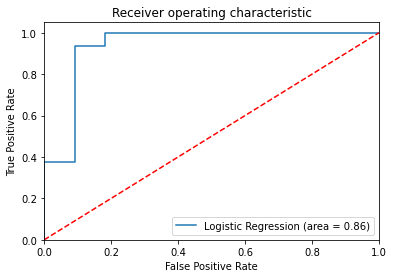

In [190]:
logit_roc_auc = roc_auc_score(cnf_ytest, clf_lr.predict(cnf_xtest))
fpr, tpr, thresholds = roc_curve(cnf_ytest, clf_lr.predict_proba(cnf_xtest)[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Influencer

In [191]:
temp_lst = []
for i in range(2, 6):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(influencer_x):
        X_train, X_test = influencer_x[train_index], influencer_x[test_index]
        y_train, y_test = influencer_y[train_index], influencer_y[test_index]
        for c in c_lst:
            clf_lr = LogisticRegression(penalty='l2', C=c, solver='newton-cg')
            clf_lr.fit(X_train, y_train)
            y_hat = clf_lr.predict(X_test)
            y_hat_prob = clf_lr.predict_proba(X_test)
            temp_lst2 = []
            temp_lst2.append(i)
            temp_lst2.append(c)
            temp_lst2.append(metrics.accuracy_score(y_train, clf_lr.predict(X_train)))
            temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
            temp_lst2.append(metrics.f1_score(y_test, y_hat, average='micro'))
            temp_lst2.append(metrics.jaccard_score(y_test, y_hat, average='micro'))
            temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst,
                       columns=['k', 'c', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
temp_lst = []
for k in range(2, 6):
    for c in c_lst:
        temp_lst2 = []
        temp_lst2.append(k)
        temp_lst2.append(c)
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Train-set Accuracy']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Test-set Accuracy']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['F1 Score']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Jaccard Score']), decimals=4))
        temp_lst.append(temp_lst2)
        
clf_lr_eval_df = pd.DataFrame(temp_lst,
                              columns=['k', 'c', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
clf_lr_eval_df

,k,c,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,0.92,0.65,0.65,0.48
1,2,0.50,0.89,0.61,0.61,0.44
2,2,0.25,0.85,0.63,0.63,0.46
3,2,0.10,0.81,0.59,0.59,0.42
4,2,0.05,0.78,0.60,0.60,0.43
5,2,0.03,0.76,0.59,0.59,0.42
6,2,0.01,0.70,0.51,0.51,0.36
7,2,0.01,0.54,0.45,0.45,0.30
8,2,0.00,0.53,0.47,0.47,0.31
9,2,0.00,0.53,0.42,0.42,0.27


In [192]:
clf_lr_eval_df.nlargest(3, 'Test-set Accuracy')

,k,c,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,0.92,0.65,0.65,0.48
30,5,1.00,0.93,0.63,0.63,0.51
2,2,0.25,0.85,0.63,0.63,0.46


In [193]:
kf = KFold(n_splits = 2)
temp_lst = []
clf_lr = LogisticRegression(penalty='l2', C=1, solver='newton-cg')
for train_index, test_index in kf.split(ad_story_x):
    X_train, X_test = ad_story_x[train_index], ad_story_x[test_index]
    y_train, y_test = ad_story_y[train_index], ad_story_y[test_index]
    clf_lr.fit(X_train, y_train)
    y_hat = clf_lr.predict(X_test)
    y_hat_prob = clf_lr.predict_proba(X_test)
    temp_lst2 = []
    temp_lst2.append(metrics.accuracy_score(y_train, clf_lr.predict(X_train)))
    temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
    temp_lst2.append(metrics.f1_score(y_test, y_hat, average='micro'))
    temp_lst2.append(metrics.jaccard_score(y_test, y_hat, average='micro'))
    temp_lst2.append(metrics.log_loss(y_test, y_hat_prob))
    temp_lst2.append(y_test)
    temp_lst2.append(y_hat)
    temp_lst2.append(X_test)
    temp_lst.append(temp_lst2)

In [194]:
temp_lst_ytest, temp_lst_yhat, temp_lst_xtest = [], [], []
for row in temp_lst:
    for i in row[5]:
        temp_lst_ytest.append(i)
    for j in row[6]:
        temp_lst_yhat.append(j)
    for k in row[7]:
        temp_lst_xtest.append(k)
    
cnf_ytest = np.array(temp_lst_ytest)
cnf_yhat = np.array(temp_lst_yhat)
cnf_xtest = np.array(temp_lst_xtest)
print(metrics.classification_report(cnf_ytest, cnf_yhat))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.76      0.81      0.79        16

    accuracy                           0.74        27
   macro avg       0.73      0.72      0.73        27
weighted avg       0.74      0.74      0.74        27



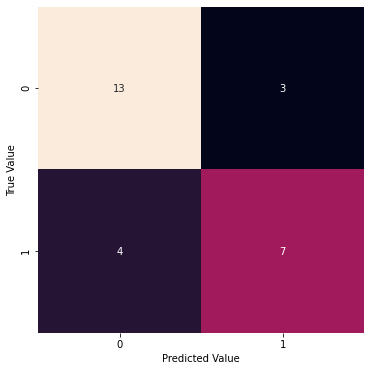

In [195]:
cnf_matrix = confusion_matrix(cnf_ytest, cnf_yhat, labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

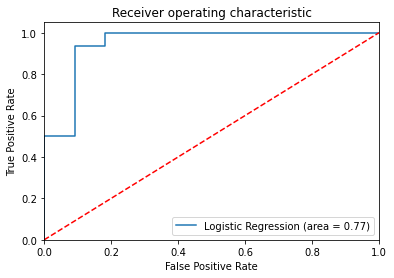

In [196]:
logit_roc_auc = roc_auc_score(cnf_ytest, clf_lr.predict(cnf_xtest))
fpr, tpr, thresholds = roc_curve(cnf_ytest, clf_lr.predict_proba(cnf_xtest)[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Leaders Post

In [197]:
temp_lst = []
for i in range(2, 6):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(leaders_post_x):
        X_train, X_test = leaders_post_x[train_index], leaders_post_x[test_index]
        y_train, y_test = leaders_post_y[train_index], leaders_post_y[test_index]
        for c in c_lst:
            clf_lr = LogisticRegression(penalty='l2', C=c, solver='newton-cg')
            clf_lr.fit(X_train, y_train)
            y_hat = clf_lr.predict(X_test)
            y_hat_prob = clf_lr.predict_proba(X_test)
            temp_lst2 = []
            temp_lst2.append(i)
            temp_lst2.append(c)
            temp_lst2.append(metrics.accuracy_score(y_train, clf_lr.predict(X_train)))
            temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
            temp_lst2.append(metrics.f1_score(y_test, y_hat, average='micro'))
            temp_lst2.append(metrics.jaccard_score(y_test, y_hat, average='micro'))
            temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst,
                       columns=['k', 'c', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
temp_lst = []
for k in range(2, 6):
    for c in c_lst:
        temp_lst2 = []
        temp_lst2.append(k)
        temp_lst2.append(c)
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Train-set Accuracy']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Test-set Accuracy']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['F1 Score']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c)]['Jaccard Score']), decimals=4))
        temp_lst.append(temp_lst2)
        
clf_lr_eval_df = pd.DataFrame(temp_lst,
                              columns=['k', 'c', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
clf_lr_eval_df

,k,c,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,1.00,0.35,0.35,0.22
1,2,0.50,1.00,0.35,0.35,0.22
2,2,0.25,0.88,0.45,0.45,0.29
3,2,0.10,0.88,0.45,0.45,0.29
4,2,0.05,0.78,0.45,0.45,0.29
5,2,0.03,0.78,0.45,0.45,0.29
6,2,0.01,0.78,0.45,0.45,0.29
7,2,0.01,0.78,0.45,0.45,0.29
8,2,0.00,0.78,0.45,0.45,0.29
9,2,0.00,0.78,0.45,0.45,0.29


In [198]:
clf_lr_eval_df.nlargest(3, 'Test-set Accuracy')

,k,c,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
36,5,0.01,0.59,0.60,0.60,0.53
37,5,0.01,0.56,0.60,0.60,0.53
38,5,0.00,0.56,0.60,0.60,0.53


In [199]:
kf = KFold(n_splits = 5)
temp_lst = []
clf_lr = LogisticRegression(penalty='l2', C=.01 ,solver='newton-cg')
for train_index, test_index in kf.split(leaders_post_x):
    X_train, X_test = leaders_post_x[train_index], leaders_post_x[test_index]
    y_train, y_test = leaders_post_y[train_index], leaders_post_y[test_index]
    clf_lr.fit(X_train, y_train)
    y_hat = clf_lr.predict(X_test)
    y_hat_prob = clf_lr.predict_proba(X_test)
    temp_lst2 = []
    temp_lst2.append(metrics.accuracy_score(y_train, clf_lr.predict(X_train)))
    temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
    temp_lst2.append(metrics.f1_score(y_test, y_hat, average='micro'))
    temp_lst2.append(metrics.jaccard_score(y_test, y_hat, average='micro'))
    temp_lst2.append(0)
    temp_lst2.append(y_test)
    temp_lst2.append(y_hat)
    temp_lst2.append(X_test)
    temp_lst.append(temp_lst2)

In [200]:
temp_lst_ytest, temp_lst_yhat, temp_lst_xtest = [], [], []
for row in temp_lst:
    for i in row[5]:
        temp_lst_ytest.append(i)
    for j in row[6]:
        temp_lst_yhat.append(j)
    for k in row[7]:
        temp_lst_xtest.append(k)
    
cnf_ytest = np.array(temp_lst_ytest)
cnf_yhat = np.array(temp_lst_yhat)
cnf_xtest = np.array(temp_lst_xtest)
print(metrics.classification_report(cnf_ytest, cnf_yhat))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.56      1.00      0.71         5
           1       0.00      0.00      0.00         2

    accuracy                           0.56         9
   macro avg       0.19      0.33      0.24         9
weighted avg       0.31      0.56      0.40         9



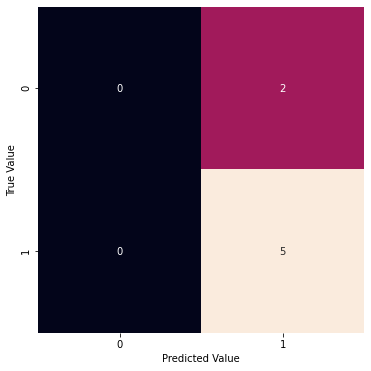

In [201]:
cnf_matrix = confusion_matrix(cnf_ytest, cnf_yhat, labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

### Support Vector Machine (Both)
#### Advertising Post

In [202]:
from sklearn.svm import SVC

In [203]:
c_lst = [1, .5, .25, .1, .05, .025, .01, .005, .0025, .001]
kernel_lst = ['linear', 'poly', 'rbf', 'sigmoid']

In [204]:
temp_lst = []
for i in range(2, 6):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_post_x):
        X_train, X_test = ad_post_x[train_index], ad_post_x[test_index]
        y_train, y_test = ad_post_y[train_index], ad_post_y[test_index]
        for c in c_lst:
            for kernel_type in kernel_lst:
                clf_svm = SVC(C=c, kernel=kernel_type)
                clf_svm.fit(X_train, y_train)
                y_hat = clf_svm.predict(X_test)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(c)
                temp_lst2.append(kernel_type)
                temp_lst2.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
                temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
                temp_lst2.append(metrics.f1_score(y_test, y_hat))
                temp_lst2.append(metrics.jaccard_score(y_test, y_hat))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst,
                       columns=['k', 'c', 'kernel', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
temp_lst = []
for k in range(2, 6):
    for c in c_lst:
        for kernel_type in kernel_lst:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(c)
            temp_lst2.append(kernel_type)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Train-set Accuracy']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Test-set Accuracy']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['F1 Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Jaccard Score']), decimals=4))
            temp_lst.append(temp_lst2)
        
clf_svm_eval_df = pd.DataFrame(temp_lst,
                              columns=['k', 'c', 'kernel', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
clf_svm_eval_df

,k,c,kernel,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,linear,0.81,0.70,0.76,0.62
1,2,1.00,poly,0.77,0.45,0.33,0.25
2,2,1.00,rbf,0.81,0.63,0.69,0.53
3,2,1.00,sigmoid,0.77,0.52,0.63,0.46
4,2,0.50,linear,0.81,0.59,0.70,0.54
5,2,0.50,poly,0.77,0.45,0.33,0.25
6,2,0.50,rbf,0.73,0.45,0.33,0.25
7,2,0.50,sigmoid,0.77,0.55,0.65,0.48
8,2,0.25,linear,0.85,0.55,0.67,0.50
9,2,0.25,poly,0.77,0.45,0.33,0.25


In [205]:
clf_svm_eval_df.nlargest(3, 'Test-set Accuracy')

,k,c,kernel,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
43,3,1.00,sigmoid,0.76,0.78,0.72,0.63
40,3,1.00,linear,0.89,0.74,0.77,0.69
44,3,0.50,linear,0.85,0.74,0.77,0.69


In [206]:
kf = KFold(n_splits = 3)
temp_lst = []
clf_svm = SVC(C=1, kernel='sigmoid')
for train_index, test_index in kf.split(ad_post_x):
    X_train, X_test = ad_post_x[train_index], ad_post_x[test_index]
    y_train, y_test = ad_post_y[train_index], ad_post_y[test_index]
    clf_svm.fit(X_train, y_train)
    y_hat = clf_svm.predict(X_test)
    temp_lst2 = []
    temp_lst2.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
    temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
    temp_lst2.append(metrics.f1_score(y_test, y_hat))
    temp_lst2.append(metrics.jaccard_score(y_test, y_hat))
    temp_lst2.append(y_test)
    temp_lst2.append(y_hat)
    temp_lst2.append(X_test)
    temp_lst.append(temp_lst2)

In [207]:
temp_lst_ytest, temp_lst_yhat, temp_lst_xtest = [], [], []
for row in temp_lst:
    for i in row[4]:
        temp_lst_ytest.append(i)
    for j in row[5]:
        temp_lst_yhat.append(j)
    for k in row[6]:
        temp_lst_xtest.append(k)
    
cnf_ytest = np.array(temp_lst_ytest)
cnf_yhat = np.array(temp_lst_yhat)
cnf_xtest = np.array(temp_lst_xtest)
print(metrics.classification_report(cnf_ytest, cnf_yhat))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.80      0.80      0.80        15

    accuracy                           0.78        27
   macro avg       0.78      0.78      0.78        27
weighted avg       0.78      0.78      0.78        27



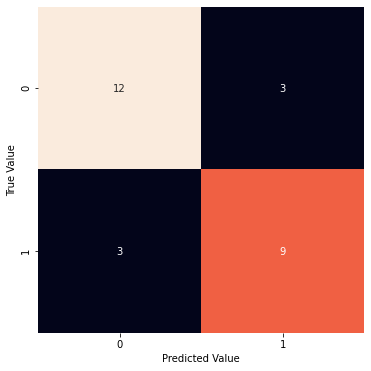

In [208]:
cnf_matrix = confusion_matrix(cnf_ytest, cnf_yhat, labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

#### Advertising Stories

In [209]:
temp_lst = []
for i in range(2, 6):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_story_x):
        X_train, X_test = ad_story_x[train_index], ad_story_x[test_index]
        y_train, y_test = ad_story_y[train_index], ad_story_y[test_index]
        for c in c_lst:
            for kernel_type in kernel_lst:
                clf_svm = SVC(C=c, kernel=kernel_type)
                clf_svm.fit(X_train, y_train)
                y_hat = clf_svm.predict(X_test)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(c)
                temp_lst2.append(kernel_type)
                temp_lst2.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
                temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
                temp_lst2.append(metrics.f1_score(y_test, y_hat))
                temp_lst2.append(metrics.jaccard_score(y_test, y_hat))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst,
                       columns=['k', 'c', 'kernel', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
temp_lst = []
for k in range(2, 6):
    for c in c_lst:
        for kernel_type in kernel_lst:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(c)
            temp_lst2.append(kernel_type)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Train-set Accuracy']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Test-set Accuracy']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['F1 Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Jaccard Score']), decimals=4))
            temp_lst.append(temp_lst2)
        
clf_svm_eval_df = pd.DataFrame(temp_lst,
                              columns=['k', 'c', 'kernel', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
clf_svm_eval_df

,k,c,kernel,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,linear,0.96,0.82,0.84,0.72
1,2,1.00,poly,0.89,0.66,0.75,0.61
2,2,1.00,rbf,0.93,0.70,0.76,0.62
3,2,1.00,sigmoid,0.85,0.63,0.72,0.57
4,2,0.50,linear,0.96,0.82,0.84,0.72
5,2,0.50,poly,0.81,0.52,0.56,0.40
6,2,0.50,rbf,0.82,0.55,0.65,0.48
7,2,0.50,sigmoid,0.74,0.59,0.70,0.55
8,2,0.25,linear,0.93,0.82,0.84,0.72
9,2,0.25,poly,0.70,0.41,0.33,0.25


In [210]:
clf_svm_eval_df.nlargest(3, 'Test-set Accuracy')

,k,c,kernel,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,linear,0.96,0.82,0.84,0.72
4,2,0.50,linear,0.96,0.82,0.84,0.72
8,2,0.25,linear,0.93,0.82,0.84,0.72


In [211]:
kf = KFold(n_splits = 2)
temp_lst = []
clf_svm = SVC(C=1, kernel='linear')
for train_index, test_index in kf.split(ad_story_x):
    X_train, X_test = ad_story_x[train_index], ad_story_x[test_index]
    y_train, y_test = ad_story_y[train_index], ad_story_y[test_index]
    clf_svm.fit(X_train, y_train)
    y_hat = clf_svm.predict(X_test)
    temp_lst2 = []
    temp_lst2.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
    temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
    temp_lst2.append(metrics.f1_score(y_test, y_hat))
    temp_lst2.append(metrics.jaccard_score(y_test, y_hat))
    temp_lst2.append(y_test)
    temp_lst2.append(y_hat)
    temp_lst2.append(X_test)
    temp_lst.append(temp_lst2)

In [212]:
temp_lst_ytest, temp_lst_yhat, temp_lst_xtest = [], [], []
for row in temp_lst:
    for i in row[4]:
        temp_lst_ytest.append(i)
    for j in row[5]:
        temp_lst_yhat.append(j)
    for k in row[6]:
        temp_lst_xtest.append(k)
    
cnf_ytest = np.array(temp_lst_ytest)
cnf_yhat = np.array(temp_lst_yhat)
cnf_xtest = np.array(temp_lst_xtest)
print(metrics.classification_report(cnf_ytest, cnf_yhat))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.87      0.81      0.84        16

    accuracy                           0.81        27
   macro avg       0.81      0.82      0.81        27
weighted avg       0.82      0.81      0.82        27



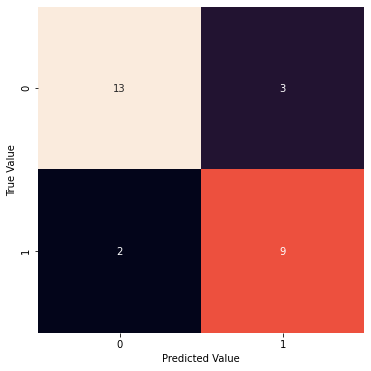

In [213]:
cnf_matrix = confusion_matrix(cnf_ytest, cnf_yhat, labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

#### Influencers

In [215]:
temp_lst = []
for i in range(2, 6):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(influencer_x):
        X_train, X_test = influencer_x[train_index], influencer_x[test_index]
        y_train, y_test = influencer_y[train_index], influencer_y[test_index]
        for c in c_lst:
            for kernel_type in kernel_lst:
                clf_svm = SVC(C=c, kernel=kernel_type)
                clf_svm.fit(X_train, y_train)
                y_hat = clf_svm.predict(X_test)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(c)
                temp_lst2.append(kernel_type)
                temp_lst2.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
                temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
                temp_lst2.append(metrics.f1_score(y_test, y_hat, average='micro'))
                temp_lst2.append(metrics.jaccard_score(y_test, y_hat, average='micro'))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst,
                       columns=['k', 'c', 'kernel', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
temp_lst = []
for k in range(2, 6):
    for c in c_lst:
        for kernel_type in kernel_lst:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(c)
            temp_lst2.append(kernel_type)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Train-set Accuracy']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Test-set Accuracy']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['F1 Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Jaccard Score']), decimals=4))
            temp_lst.append(temp_lst2)
        
clf_svm_eval_df = pd.DataFrame(temp_lst,
                              columns=['k', 'c', 'kernel', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
clf_svm_eval_df

,k,c,kernel,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,linear,0.89,0.68,0.68,0.51
1,2,1.00,poly,0.85,0.55,0.55,0.38
2,2,1.00,rbf,0.83,0.58,0.58,0.41
3,2,1.00,sigmoid,0.74,0.67,0.67,0.50
4,2,0.50,linear,0.88,0.58,0.58,0.41
5,2,0.50,poly,0.75,0.53,0.53,0.36
6,2,0.50,rbf,0.80,0.52,0.52,0.35
7,2,0.50,sigmoid,0.70,0.66,0.66,0.49
8,2,0.25,linear,0.83,0.58,0.58,0.41
9,2,0.25,poly,0.65,0.50,0.50,0.34


In [216]:
clf_svm_eval_df.nlargest(3, 'Test-set Accuracy')

,k,c,kernel,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
120,5,1.00,linear,0.93,0.71,0.71,0.59
0,2,1.00,linear,0.89,0.68,0.68,0.51
3,2,1.00,sigmoid,0.74,0.67,0.67,0.50


In [217]:
kf = KFold(n_splits = 5)
temp_lst = []
clf_svm = SVC(C=1, kernel='linear')
for train_index, test_index in kf.split(influencer_x):
    X_train, X_test = influencer_x[train_index], influencer_x[test_index]
    y_train, y_test = influencer_y[train_index], influencer_y[test_index]
    clf_svm.fit(X_train, y_train)
    y_hat = clf_svm.predict(X_test)
    temp_lst2 = []
    temp_lst2.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
    temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
    temp_lst2.append(metrics.f1_score(y_test, y_hat, average='micro'))
    temp_lst2.append(metrics.jaccard_score(y_test, y_hat, average='micro'))
    temp_lst2.append(y_test)
    temp_lst2.append(y_hat)
    temp_lst2.append(X_test)
    temp_lst.append(temp_lst2)

In [218]:
temp_lst_ytest, temp_lst_yhat, temp_lst_xtest = [], [], []
for row in temp_lst:
    for i in row[4]:
        temp_lst_ytest.append(i)
    for j in row[5]:
        temp_lst_yhat.append(j)
    for k in row[6]:
        temp_lst_xtest.append(k)
    
cnf_ytest = np.array(temp_lst_ytest)
cnf_yhat = np.array(temp_lst_yhat)
cnf_xtest = np.array(temp_lst_xtest)
print(metrics.classification_report(cnf_ytest, cnf_yhat))

              precision    recall  f1-score   support

          -1       0.82      0.61      0.70        23
           0       0.60      0.91      0.72        43
           1       0.95      0.53      0.68        36

    accuracy                           0.71       102
   macro avg       0.79      0.68      0.70       102
weighted avg       0.77      0.71      0.70       102



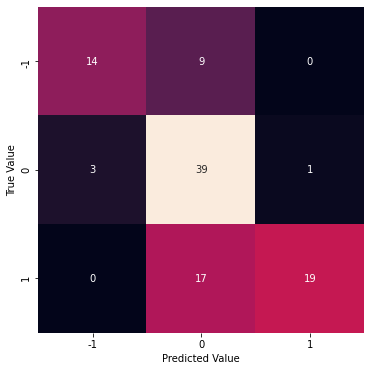

In [234]:
cnf_matrix = confusion_matrix(cnf_ytest, cnf_yhat)
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False)
plt.xticks([.5, 1.5, 2.5], [-1, 0, 1])
plt.yticks([.5, 1.5, 2.5], [-1, 0, 1])
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

#### Leaders Post

In [235]:
temp_lst = []
for i in range(2, 6):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(leaders_post_x):
        X_train, X_test = leaders_post_x[train_index], leaders_post_x[test_index]
        y_train, y_test = leaders_post_y[train_index], leaders_post_y[test_index]
        for c in c_lst:
            for kernel_type in kernel_lst:
                clf_svm = SVC(C=c, kernel=kernel_type)
                clf_svm.fit(X_train, y_train)
                y_hat = clf_svm.predict(X_test)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(c)
                temp_lst2.append(kernel_type)
                temp_lst2.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
                temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
                temp_lst2.append(metrics.f1_score(y_test, y_hat, average='micro'))
                temp_lst2.append(metrics.jaccard_score(y_test, y_hat, average='micro'))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst,
                       columns=['k', 'c', 'kernel', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
temp_lst = []
for k in range(2, 6):
    for c in c_lst:
        for kernel_type in kernel_lst:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(c)
            temp_lst2.append(kernel_type)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Train-set Accuracy']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Test-set Accuracy']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['F1 Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['c'] == c) & (temp_df['kernel'] == kernel_type)]['Jaccard Score']), decimals=4))
            temp_lst.append(temp_lst2)
        
clf_svm_eval_df = pd.DataFrame(temp_lst,
                              columns=['k', 'c', 'kernel', 'Train-set Accuracy', 'Test-set Accuracy', 'F1 Score', 'Jaccard Score'])
clf_svm_eval_df

,k,c,kernel,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
0,2,1.00,linear,1.00,0.35,0.35,0.22
1,2,1.00,poly,0.78,0.57,0.57,0.42
2,2,1.00,rbf,1.00,0.45,0.45,0.29
3,2,1.00,sigmoid,0.78,0.45,0.45,0.29
4,2,0.50,linear,1.00,0.35,0.35,0.22
5,2,0.50,poly,0.78,0.57,0.57,0.42
6,2,0.50,rbf,0.78,0.45,0.45,0.29
7,2,0.50,sigmoid,0.78,0.45,0.45,0.29
8,2,0.25,linear,1.00,0.35,0.35,0.22
9,2,0.25,poly,0.68,0.57,0.57,0.42


In [237]:
clf_svm_eval_df.nlargest(3, 'Test-set Accuracy')

,k,c,kernel,Train-set Accuracy,Test-set Accuracy,F1 Score,Jaccard Score
125,5,0.50,poly,0.78,0.60,0.60,0.53
126,5,0.50,rbf,0.61,0.60,0.60,0.53
129,5,0.25,poly,0.67,0.60,0.60,0.53


In [238]:
kf = KFold(n_splits = 5)
temp_lst = []
clf_svm = SVC(C=1, kernel='linear')
for train_index, test_index in kf.split(leaders_post_x):
    X_train, X_test = leaders_post_x[train_index], leaders_post_x[test_index]
    y_train, y_test = leaders_post_y[train_index], leaders_post_y[test_index]
    clf_svm.fit(X_train, y_train)
    y_hat = clf_svm.predict(X_test)
    temp_lst2 = []
    temp_lst2.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
    temp_lst2.append(metrics.accuracy_score(y_test, y_hat))
    temp_lst2.append(metrics.f1_score(y_test, y_hat, average='micro'))
    temp_lst2.append(metrics.jaccard_score(y_test, y_hat, average='micro'))
    temp_lst2.append(y_test)
    temp_lst2.append(y_hat)
    temp_lst2.append(X_test)
    temp_lst.append(temp_lst2)

In [239]:
temp_lst_ytest, temp_lst_yhat, temp_lst_xtest = [], [], []
for row in temp_lst:
    for i in row[4]:
        temp_lst_ytest.append(i)
    for j in row[5]:
        temp_lst_yhat.append(j)
    for k in row[6]:
        temp_lst_xtest.append(k)
    
cnf_ytest = np.array(temp_lst_ytest)
cnf_yhat = np.array(temp_lst_yhat)
cnf_xtest = np.array(temp_lst_xtest)
print(metrics.classification_report(cnf_ytest, cnf_yhat))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.50      0.80      0.62         5
           1       0.00      0.00      0.00         2

    accuracy                           0.44         9
   macro avg       0.17      0.27      0.21         9
weighted avg       0.28      0.44      0.34         9



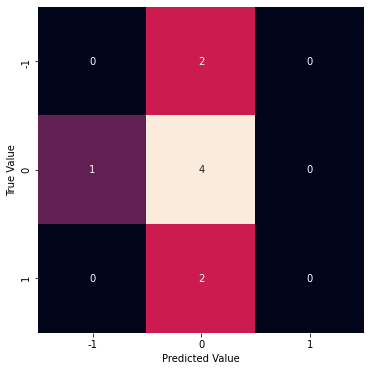

In [240]:
cnf_matrix = confusion_matrix(cnf_ytest, cnf_yhat)
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False)
plt.xticks([.5, 1.5, 2.5], [-1, 0, 1])
plt.yticks([.5, 1.5, 2.5], [-1, 0, 1])
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

### K-Nearest Neighbor
#### Advertising Posts

### Decision Tree
#### Advertising Posts

### Random Forest
#### Advertising Posts

### Gradient Boosting
#### Advertising Posts